Install dependencies

In [43]:
!pip install --upgrade -r requirements.txt
!sudo apt-get install -y ffmpeg mkvtoolnix

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
mkvtoolnix is already the newest version (54.0.0+really52.0.0-3).
ffmpeg is already the newest version (7:4.3.6-0+deb11u1).
0 upgraded, 0 newly installed, 0 to remove and 0 not upgraded.


Detect scenes

In [44]:
from scenedetect import detect, ContentDetector
fn = "[a-s]_mobile_fighter_g_gundam_-_03_-_beat_the_dragon_gundam__rs2_[0678D2EE].mkv"
scene_list = detect(fn, ContentDetector())
print(scene_list)

[(00:00:00.000 [frame=0, fps=23.976], 00:00:04.338 [frame=104, fps=23.976]), (00:00:04.338 [frame=104, fps=23.976], 00:00:06.548 [frame=157, fps=23.976]), (00:00:06.548 [frame=157, fps=23.976], 00:00:09.509 [frame=228, fps=23.976]), (00:00:09.509 [frame=228, fps=23.976], 00:00:10.302 [frame=247, fps=23.976]), (00:00:10.302 [frame=247, fps=23.976], 00:00:10.928 [frame=262, fps=23.976]), (00:00:10.928 [frame=262, fps=23.976], 00:00:12.095 [frame=290, fps=23.976]), (00:00:12.095 [frame=290, fps=23.976], 00:00:12.763 [frame=306, fps=23.976]), (00:00:12.763 [frame=306, fps=23.976], 00:00:19.811 [frame=475, fps=23.976]), (00:00:19.811 [frame=475, fps=23.976], 00:00:26.777 [frame=642, fps=23.976]), (00:00:26.777 [frame=642, fps=23.976], 00:00:27.778 [frame=666, fps=23.976]), (00:00:27.778 [frame=666, fps=23.976], 00:00:29.029 [frame=696, fps=23.976]), (00:00:29.029 [frame=696, fps=23.976], 00:00:31.365 [frame=752, fps=23.976]), (00:00:31.365 [frame=752, fps=23.976], 00:00:32.241 [frame=773, f

Print scenes (DEBUG)

In [46]:
for i, scene in enumerate(scene_list):
    print('Scene %2d: Start %s / Frame %d, End %s / Frame %d' % (
        i+1,
        scene[0].get_timecode(), scene[0].get_frames(),
        scene[1].get_timecode(), scene[1].get_frames(),))

Scene  1: Start 00:00:00.000 / Frame 0, End 00:00:04.338 / Frame 104
Scene  2: Start 00:00:04.338 / Frame 104, End 00:00:06.548 / Frame 157
Scene  3: Start 00:00:06.548 / Frame 157, End 00:00:09.509 / Frame 228
Scene  4: Start 00:00:09.509 / Frame 228, End 00:00:10.302 / Frame 247
Scene  5: Start 00:00:10.302 / Frame 247, End 00:00:10.928 / Frame 262
Scene  6: Start 00:00:10.928 / Frame 262, End 00:00:12.095 / Frame 290
Scene  7: Start 00:00:12.095 / Frame 290, End 00:00:12.763 / Frame 306
Scene  8: Start 00:00:12.763 / Frame 306, End 00:00:19.811 / Frame 475
Scene  9: Start 00:00:19.811 / Frame 475, End 00:00:26.777 / Frame 642
Scene 10: Start 00:00:26.777 / Frame 642, End 00:00:27.778 / Frame 666
Scene 11: Start 00:00:27.778 / Frame 666, End 00:00:29.029 / Frame 696
Scene 12: Start 00:00:29.029 / Frame 696, End 00:00:31.365 / Frame 752
Scene 13: Start 00:00:31.365 / Frame 752, End 00:00:32.241 / Frame 773
Scene 14: Start 00:00:32.241 / Frame 773, End 00:00:32.866 / Frame 788
Scene 15

FFT to detect areas of high frequency shift

[(0, 2157, 52), (239, 2396, 50), (478, 2635, 48), (717, 2874, 48), (956, 3113, 43), (1195, 3352, 38), (1434, 3591, 29), (1673, 3830, 19), (1912, 4069, 17), (2151, 4308, 20), (2390, 4547, 20), (2629, 4786, 19), (2868, 5025, 19), (3107, 5264, 23), (3346, 5503, 27), (3585, 5742, 32), (3824, 5981, 36), (4063, 6220, 34), (4302, 6459, 32), (4541, 6698, 37), (4780, 6937, 37), (5019, 7176, 41), (5258, 7415, 39), (5497, 7654, 40), (5736, 7893, 36), (5975, 8132, 34), (6214, 8371, 35), (6453, 8610, 34), (6692, 8849, 30), (6931, 9088, 30), (7170, 9327, 26), (7409, 9566, 24), (7648, 9805, 23), (7887, 10044, 20), (8126, 10283, 18), (8365, 10522, 19), (8604, 10761, 22), (8843, 11000, 26), (9082, 11239, 27), (9321, 11478, 26), (9560, 11717, 30), (9799, 11956, 30), (10038, 12195, 33), (10277, 12434, 35), (10516, 12673, 34), (10755, 12912, 29), (10994, 13151, 25), (11233, 13390, 22), (11472, 13629, 20), (11711, 13868, 19), (11950, 14107, 17), (12189, 14346, 18), (12428, 14585, 18), (12667, 14824, 19), (

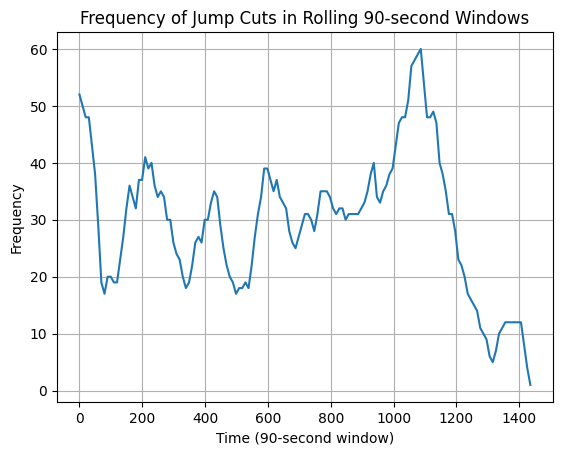

In [47]:
import numpy as np
import matplotlib.pyplot as plt
from math import ceil, floor

# Get list of frames
frames = np.array([x[0].get_frames() for x in scene_list])

# Set up loop iteration
window_seconds = 90
step_seconds = 10
frame_rate = scene_list[0][0].get_framerate()  # Replace this with the actual frame rate of your video.

frame_step = int(step_seconds * frame_rate)
window_frames = int(window_seconds * frame_rate)

last_scene = scene_list[-1][1].get_frames()
transitions = []

# Loop over every frame window in the range, determining how many transitions were in the window
for i, frame in enumerate(range(0, last_scene, frame_step)):
    transition_count = 0
    frame_range = (frame, frame + window_frames)
    # if start of scene falls within our window, count it as one transition
    for scene in scene_list:
        if scene[0].get_frames() < frame_range[0]:
            continue
        elif frame_range[0] <= scene[0].get_frames() < frame_range[1]:
            transition_count += 1
        elif scene[0].get_frames() >= frame_range[1]:
            break
    transitions.append((frame_range[0], frame_range[1], transition_count))
print(transitions)

# get frequency counts
frequency_counts = [x[2] for x in transitions]
frame_window = [x[0] / frame_rate for x in transitions]

# Plot the frequency graph in rolling 90-second windows.
plt.plot(frame_window, frequency_counts)
plt.xlabel('Time (90-second window)')
plt.ylabel('Frequency')
plt.title('Frequency of Jump Cuts in Rolling 90-second Windows')
plt.grid(True)
plt.show()



Our frequency analysis actually shows that the op has the second highest level of jump cutsS
Possibilities:
 - The jump cuts are not detected
 - There are actually fewer jump cuts in the opening than in the rest of the anime
 - This episode has a heavy action sequence at 1100s that is even more high freq than the op
